In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# loading MNIST ttrain dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../data',
        train=True,
        download=True,
        transform=transforms.Compose([
            transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ])),
    batch_size=batch_size,
    shuffle=True,
    **kwargs)


# loading MNIST test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../data',
        train=False,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
    batch_size=batch_size,
    shuffle=True,
    **kwargs)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:10<00:00, 906kB/s] 


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.99MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
# visualize the dataset
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

torch.Size([128, 1, 28, 28])

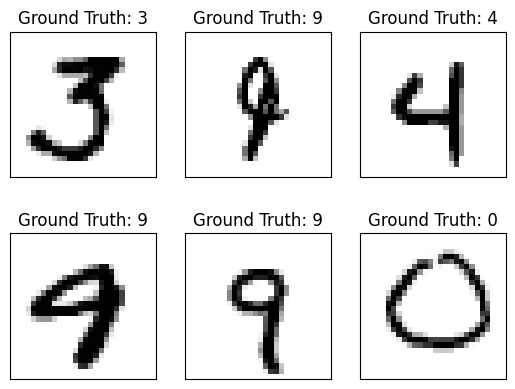

In [ ]:
# visualize the dataset and plotting in a graph
import matplotlib.pyplot as plt

fig = plt.figure()

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(example_data[i][0].numpy().squeeze(), cmap='gray_r', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


In [ ]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, 3, padding=0)
        self.bnorm1 = nn.BatchNorm2d(16)
        # 28 -> 26 x 26 x 8 | RF - 3

        self.conv2 = nn.Conv2d(16, 32, 3, padding=0)
        self.bnorm2 = nn.BatchNorm2d(32)
        # 26 -> 24 x 24 x 16 | RF - 5

        self.noconv1 = nn.Conv2d(32, 16, 1)
        # 24 -> 24 x 24 x 16 | RF - 5

        self.pool1 = nn.MaxPool2d(2, 2)
        # 24 -> 12 x 12 x 16 | RF - 6

        self.conv3 = nn.Conv2d(16, 16, 3, padding=0)
        self.bnorm3 = nn.BatchNorm2d(16)
        # 12 -> 10 x 10 x 16 | RF - 10

        self.conv4 = nn.Conv2d(16, 16, 3, padding=0)
        self.bnorm4 = nn.BatchNorm2d(16)
        # 10 -> 8 x 8 x 16 | RF - 14

        self.conv5 = nn.Conv2d(16, 16, 3, padding=0)
        self.bnorm5 = nn.BatchNorm2d(16)
        # 8 -> 6 x 6 x 16 | RF - 1

        self.conv6 = nn.Conv2d(16, 16, 3, padding=0)
        self.bnorm6 = nn.BatchNorm2d(16)
        # 6 -> 4 x 4 x 32 | RF - 22

        self.drop = nn.Dropout2d(0.1)

        self.gap = nn.AvgPool2d(4)
        # 4 x 4 x 32 -> 1 x 1 x 32 | RF - 28

        self.noconv2 = nn.Conv2d(16, 10, 1)
        # 1 x 1 x 32 -> 1 x 1 x 10 | RF - 28


    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = F.relu(self.conv1(x))
        x = self.bnorm1(x)
        x = self.drop(x)

        x = F.relu(self.conv2(x))
        x = self.bnorm2(x)
        x = self.drop(x)

        x = self.noconv1(x)

        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = self.bnorm3(x)
        x = self.drop(x)

        x = F.relu(self.conv4(x))
        x = self.bnorm4(x)
        x = self.drop(x)

        x = F.relu(self.conv5(x))
        x = self.bnorm5(x)
        x = self.drop(x)

        x = F.relu(self.conv6(x))
        x = self.bnorm6(x)
        x = self.drop(x)

        x = self.gap(x)

        x = self.noconv2(x)

        x = x.view(-1, 10)

        # Log softmax for the output
        return F.log_softmax(x, dim=1)

In [ ]:
model = MNISTNet().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
         Dropout2d-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 32, 24, 24]           4,640
       BatchNorm2d-5           [-1, 32, 24, 24]              64
         Dropout2d-6           [-1, 32, 24, 24]               0
            Conv2d-7           [-1, 16, 24, 24]             528
         MaxPool2d-8           [-1, 16, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           2,320
      BatchNorm2d-10           [-1, 16, 10, 10]              32
        Dropout2d-11           [-1, 16, 10, 10]               0
           Conv2d-12             [-1, 16, 8, 8]           2,320
      BatchNorm2d-13             [-1, 16, 8, 8]              32
        Dropout2d-14             [-1, 1

In [ ]:
from torch.optim.lr_scheduler import StepLR

model = MNISTNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(1, 20):
    print(f"Epoch: {epoch}")
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

Epoch: 1


Loss=0.16026796400547028 Batch_id=468 Accuracy=87.22: 100%|██████████| 469/469 [00:31<00:00, 15.08it/s]



Test set: Average loss: 0.0636, Accuracy: 9811/10000 (98%)

Epoch: 2


Loss=0.19185452163219452 Batch_id=468 Accuracy=96.30: 100%|██████████| 469/469 [00:25<00:00, 18.12it/s]



Test set: Average loss: 0.0387, Accuracy: 9881/10000 (99%)

Epoch: 3


Loss=0.16453133523464203 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:25<00:00, 18.69it/s]



Test set: Average loss: 0.0325, Accuracy: 9892/10000 (99%)

Epoch: 4


Loss=0.05759792402386665 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:25<00:00, 18.60it/s]



Test set: Average loss: 0.0355, Accuracy: 9886/10000 (99%)

Epoch: 5


Loss=0.0405111126601696 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:25<00:00, 18.50it/s]



Test set: Average loss: 0.0277, Accuracy: 9915/10000 (99%)

Epoch: 6


Loss=0.05384082719683647 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:24<00:00, 18.85it/s]



Test set: Average loss: 0.0259, Accuracy: 9916/10000 (99%)

Epoch: 7


Loss=0.06405875831842422 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:25<00:00, 18.65it/s]



Test set: Average loss: 0.0219, Accuracy: 9933/10000 (99%)

Epoch: 8


Loss=0.07625047862529755 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:25<00:00, 18.46it/s]



Test set: Average loss: 0.0208, Accuracy: 9940/10000 (99%)

Epoch: 9


Loss=0.01993304304778576 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:25<00:00, 18.63it/s]



Test set: Average loss: 0.0212, Accuracy: 9935/10000 (99%)

Epoch: 10


Loss=0.0198714267462492 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:24<00:00, 18.80it/s]



Test set: Average loss: 0.0201, Accuracy: 9937/10000 (99%)

Epoch: 11


Loss=0.07348383963108063 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:26<00:00, 17.78it/s]



Test set: Average loss: 0.0200, Accuracy: 9933/10000 (99%)

Epoch: 12


Loss=0.021275749430060387 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:25<00:00, 18.58it/s]



Test set: Average loss: 0.0202, Accuracy: 9943/10000 (99%)

Epoch: 13


Loss=0.09030702710151672 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:25<00:00, 18.64it/s]



Test set: Average loss: 0.0201, Accuracy: 9935/10000 (99%)

Epoch: 14


Loss=0.026580343022942543 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:25<00:00, 18.28it/s]



Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99%)

Epoch: 15


Loss=0.06954443454742432 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:25<00:00, 18.39it/s]



Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99%)

Epoch: 16


Loss=0.039082158356904984 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:25<00:00, 18.31it/s]



Test set: Average loss: 0.0203, Accuracy: 9938/10000 (99%)

Epoch: 17


Loss=0.03426459804177284 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:25<00:00, 18.67it/s]



Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99%)

Epoch: 18


Loss=0.09138645976781845 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:25<00:00, 18.66it/s]



Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99%)

Epoch: 19


Loss=0.03301598131656647 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:25<00:00, 18.55it/s]



Test set: Average loss: 0.0197, Accuracy: 9941/10000 (99%)

